# Customer, Offer and Transaction Analysis

# Objective
The goal of this analysis is to explore customer behavior, offer interactions, and transactions patterns to derive insights that could improve targeting and engagement strategies.


### Dataset Overview

- **offers_df**: Contains details like `offer_type`, `min_value`, `duration`, `discount_value`
- **profile_df**: Customer demographics such as `age`, `gender`, `credit_card_limit`, and registration date
- **transactions_df**: Event logs including transactions and offer interactions

---
This notebook is structured as follows: 
1. Processing offers.json 
2. Processing profile.json 
3. Processing transactions.json 
4. Unifying datasets
5. Feature engineering
6. Preparing Training dataset


---

## Exploratory Data Analysis (EDA)

### Offers
- Distribution of `offer_type`
- Histograms of `min_value`, `discount_value`, `duration`
- Channels used for distribution

### Customers
- Distribution of `gender`, `age`, and `credit_card_limit`
- Outlier detection (e.g., customers over 100 years old or unknown credit limits)
- Age group segmentation

### Transactions
- Event counts by type
- Distribution of `amount` and `reward`
- Transaction volume vs. time

---

## Behavioral Analysis

### Offer Conversion Funnel
- Offer Received → Viewed → Completed analysis
- Conversion rate calculation and pie chart

### Time to Completion
- Histogram of `time_to_complete`
- Average days to complete an offer

### Spending and Analysis
- Average `total_spent` for users who completed vs. did not complete offers
- Bar plot comparison
- Pearson correlation matrix for numerical variables

---

# Insights and Recommendations

- Over **58% of received offers** were completed — strong user engagement.
- Users who **complete offers spend significantly more** (~3x on average).
- `reward` and `discount_value` are duplicates and should not be used together.
- Age and credit card limit are moderately correlated (r ≈ 0.41).
- No significant linear correlation between account age and engagement.

---

In [0]:
# Numerical computing and data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical tests
from scipy.stats import pearsonr, spearmanr

# PySpark core and utilities
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, explode, when, to_date, from_unixtime, round, coalesce,
    current_date, datediff, sum, count, expr, size, collect_set, avg, lit
)
from pyspark.sql.types import (
    StructType, StructField, StringType, IntegerType, FloatType, ArrayType
)
from pyspark.sql.window import Window

# iFood brand color palette
ifood_palette = {
    "light_pink":      "#F49484",
    "mid_pink":        "#FB8B9C",
    "coral":           "#E4737B",
    "pink":            "#DA5265",
    "ifood_red":       "#EA1D2C",
    "dark_red":        "#BB303E",
    "highlight_green": "#63B76C",
    "black":           "#333333"
}


In [0]:
# Reading datasets
offers_df = spark.read.json("/Volumes/workspace/default/data/offers.json")
profile_df = spark.read.json("/Volumes/workspace/default/data/profile.json")
transactions_df = spark.read.json("/Volumes/workspace/default/data/transactions.json")



### 1. Processing **offers.json**

This dataset contains metadata for each marketing offer available in the platform.

**Steps performed:**

1. **Reading and visualizing table**: First rows were visualized for inspection.
2. **Column renaming**: The original `id` column was renamed to `offer_id` to allow proper joining with the transactional data using `offer_id` as the key.
3. **Exploratory Data Analysis**:
   - Plotted **category distribution** to understand the frequency of different offer strategies.
   - Created **boxplots** for numerical features to identify spread, typical ranges, and potential outliers.


In [0]:
# summary of offers dataset
offers_df.describe().show()

offers_df.select(explode("channels").alias("channel")) \
         .groupBy("channel").count() \
         .orderBy("count", ascending=False) \
         .show()


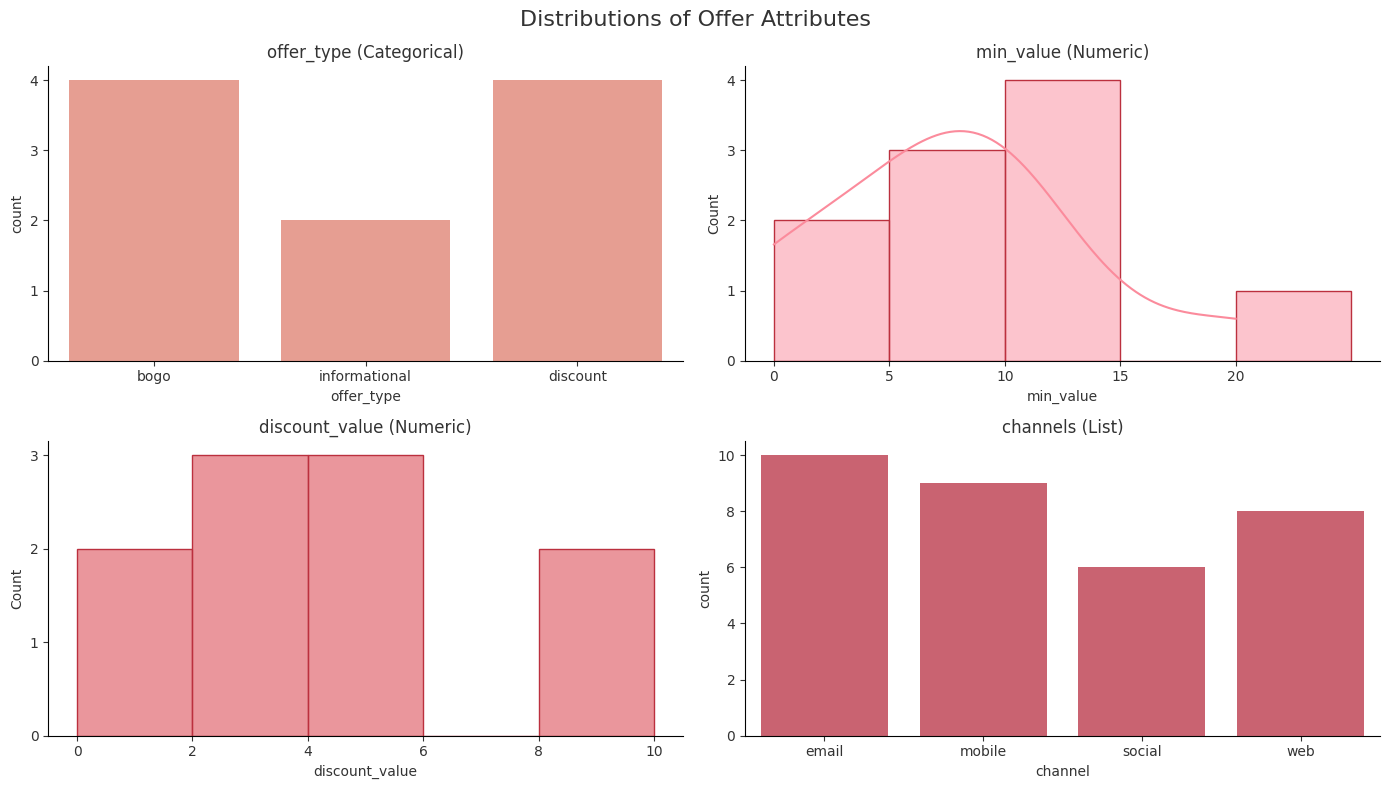

In [0]:
# Plotting each column distribution 
offers_pd = offers_df.toPandas()
fig, axes = plt.subplots(2, 2, figsize=(14, 8), dpi=100)
fig.suptitle("Distributions of Offer Attributes", fontsize=16, color=ifood_palette["black"])

# Plot 1: offer_type (categorical) 
sns.countplot(data=offers_pd, x="offer_type", 
              color=ifood_palette["light_pink"],
              ax=axes[0, 0])
axes[0, 0].set_title("offer_type (Categorical)", color=ifood_palette["black"])
axes[0, 0].set_yticks(np.arange(0, 5, 1))  

# Plot 2: min_value (numeric)  
sns.histplot(offers_pd["min_value"], 
             bins=[0, 5, 10, 15, 20, 25],
             kde=True,
             ax=axes[0, 1],
             color=ifood_palette["mid_pink"], edgecolor=ifood_palette["dark_red"])

axes[0, 1].set_title("min_value (Numeric)", color=ifood_palette["black"])
axes[0, 1].set_xticks(np.arange(0, 21, 5))
axes[0, 1].set_yticks(np.arange(0, 5, 1))

# Plot 3: discount_value (numeric)
sns.histplot(offers_pd["discount_value"], ax=axes[1, 0], color=ifood_palette["coral"], edgecolor=ifood_palette["dark_red"])
axes[1, 0].set_title("discount_value (Numeric)", color=ifood_palette["black"])
axes[1, 0].set_xticks(np.arange(0, 11, 2)) 
axes[1, 0].set_yticks(np.arange(0, 4, 1))  

# Plot 4: channels (categorical list) ''
channels_exploded_df = offers_df.select(explode("channels").alias("channel"))
channels_exploded = channels_exploded_df.toPandas()["channel"]
sns.countplot(x=channels_exploded, ax=axes[1, 1], color=ifood_palette["pink"])
axes[1, 1].set_title("channels (List)", color=ifood_palette["black"])


# Axis and details adjustments
for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), color=ifood_palette["black"])
    ax.set_ylabel(ax.get_ylabel(), color=ifood_palette["black"])
    ax.tick_params(colors=ifood_palette["black"])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

# Layout final e salvamento
plt.tight_layout()
plt.show()


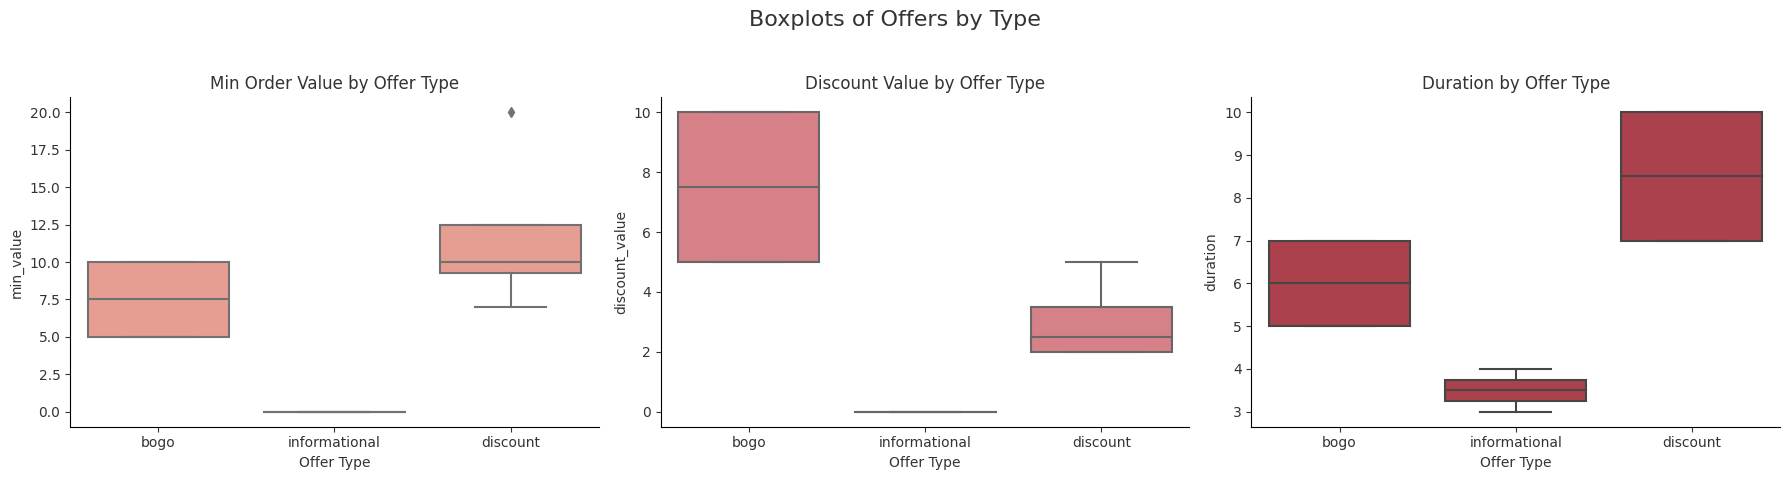

In [0]:
# Plotting boxplot
fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=100)
fig.suptitle("Boxplots of Offers by Type", fontsize=16, color=ifood_palette["black"])

# Boxplot 1: min_value vs offer_type
sns.boxplot(data=offers_pd, x="offer_type", y="min_value", ax=axes[0], color=ifood_palette["light_pink"])
axes[0].set_title("Min Order Value by Offer Type", color=ifood_palette["black"])

# Boxplot 2: discount_value vs offer_type
sns.boxplot(data=offers_pd, x="offer_type", y="discount_value", ax=axes[1], color=ifood_palette["coral"])
axes[1].set_title("Discount Value by Offer Type", color=ifood_palette["black"])

# Boxplot 3: duration vs offer_type
sns.boxplot(data=offers_pd, x="offer_type", y="duration", ax=axes[2], color=ifood_palette["dark_red"])
axes[2].set_title("Duration by Offer Type", color=ifood_palette["black"])


for ax in axes:
    ax.set_xlabel("Offer Type", color=ifood_palette["black"])
    ax.set_ylabel(ax.get_ylabel(), color=ifood_palette["black"])
    ax.tick_params(colors=ifood_palette["black"])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [0]:
offers_df = offers_df.withColumnRenamed("id", "offer_id")

# # Saving file 
(
    offers_df
    .coalesce(1)                  
    .write
    .mode("overwrite")
    .json("/Volumes/workspace/default/data/offers_processed.json")
)

### 2. Processing **profile.json**

This dataset contains demographic and financial information about approximately 17,000 customers.

**Steps performed:**

1. **Reading and inspecting the data**: Displayed summary statistics and null distributions.

2. **Data cleaning**:
   - Parsed `registered_on`, converted it to date format, and calculated `account_age_years`.
   - Handled missing values and outliers:
      - Filled missing `gender` values with `"not_specified"`.
      - Replaced missing or invalid credit card limits with the placeholder value `1`.
      - Identified and flagged outlier ages (e.g., `age > 100`).

3. **Grouping variables for visualization**:
   - Created grouped variables to facilitate analysis:
     - `age_group`: binned ages into custom age ranges.
     - `credit_limit_group`: binned credit card limits into income-like ranges.

4. **Exploratory analysis**:
   - Plotted categorical distributions (e.g., gender, age group, credit limit group).
   - Created boxplots comparing account age and credit limits across demographic groups.
   - Computed Pearson correlations between key numerical variables to assess linear relationships.


In [0]:
profile_df.describe().show()

In [0]:
# Outlier Detection Section

profile_df = profile_df.withColumn("outlier_age", col("age") > 100)
profile_df = profile_df.fillna({"gender": "not_specified"})
profile_df = profile_df.fillna({"credit_card_limit": 1})

df_outliers = profile_df.filter(
    (col("outlier_age") == True) |
    (col("gender") == "not_specified") |
    (col("credit_card_limit") == 1)
)

In [0]:
profile_df = profile_df.withColumnRenamed("id", "account_id")

profile_df.select(
    sum(col("outlier_age").cast("int")).alias("n_outlier_age"),
    sum((col("gender") == "not_specified").cast("int")).alias("n_missing_gender"),
    sum((col("credit_card_limit") == 1).cast("int")).alias("n_missing_credit_limit")
).show()

In [0]:
# Create binary flags for each data quality condition
df_flags = profile_df.select(
    "account_id",
    (col("outlier_age") == True).cast("int").alias("is_outlier_age"),
    (col("gender") == "not_specified").cast("int").alias("is_missing_gender"),
    (col("credit_card_limit") == 1).cast("int").alias("is_missing_credit")
)

# count occurrences by groups
intersection_df = (
    df_flags
    .groupBy("is_outlier_age", "is_missing_gender", "is_missing_credit")
    .count()
    .orderBy("count", ascending=False)
)

display(intersection_df)

# 2175 users are missing both gender and credit card limit values — the most common issue.
# 5 users have all three problems simultaneously: age > 100, missing gender, and credit card limit = 1.
# 14,820 users (87,18% of dataset) do not exhibit any of the flagged conditions — this is the clean majority of the dataset.


is_outlier_age is_missing_gender is_missing_credit count 0 0 0 14820 1 1 1 2175 1 0 0 5

In [0]:
# CAlculate time in app in years
profile_df = profile_df.withColumn("registered_on_date", to_date(col("registered_on").cast("string"), "yyyyMMdd"))
profile_df = profile_df.withColumn("account_age_years", round(datediff(current_date(), col("registered_on_date")) / 365,2))
profile_df = profile_df.drop("registered_on")

profile_df = profile_df.withColumn(
    "account_age_group",
    when(col("account_age_years") <= 0.082, "0–30 dias")
    .when(col("account_age_years") <= 0.493, "31–180 dias")
    .when(col("account_age_years") <= 1.0, "181–365 dias")
    .when(col("account_age_years") <= 2.0, "1–2 anos")
    .when(col("account_age_years") <= 5.0, "2–5 anos")
    .otherwise("+5 anos")
)

# Create age group categories for analysis and visualization
profile_df = profile_df.withColumn(
    "age_group",
    when((col("age") >= 18) & (col("age") <= 30), "18-30")
    .when((col("age") <= 40), "31-40")
    .when((col("age") <= 50), "41-50")
    .when((col("age") <= 60), "51-60")
    .when((col("age") <= 70), "61-70")
    .when((col("age") <= 80), "71-80")
    .otherwise("80+")
)

# Group credit card limit
profile_df = profile_df.withColumn(
    "credit_limit_group",
    when(col("credit_card_limit") == 1, "unknown")
    .when(col("credit_card_limit") <= 10000, "≤10K")
    .when(col("credit_card_limit") <= 20000, "10K–20K")
    .when(col("credit_card_limit") <= 30000, "20K–30K")
    .when(col("credit_card_limit") <= 40000, "30K–40K")
    .when(col("credit_card_limit") <= 50000, "40K–50K")
    .when(col("credit_card_limit") <= 60000, "50K–60K")
    .when(col("credit_card_limit") <= 80000, "60K–80K")
    .when(col("credit_card_limit") <= 100000, "80K–100K")
    .when(col("credit_card_limit") <= 120000, "100K–120K")
    .otherwise("120K+")
)

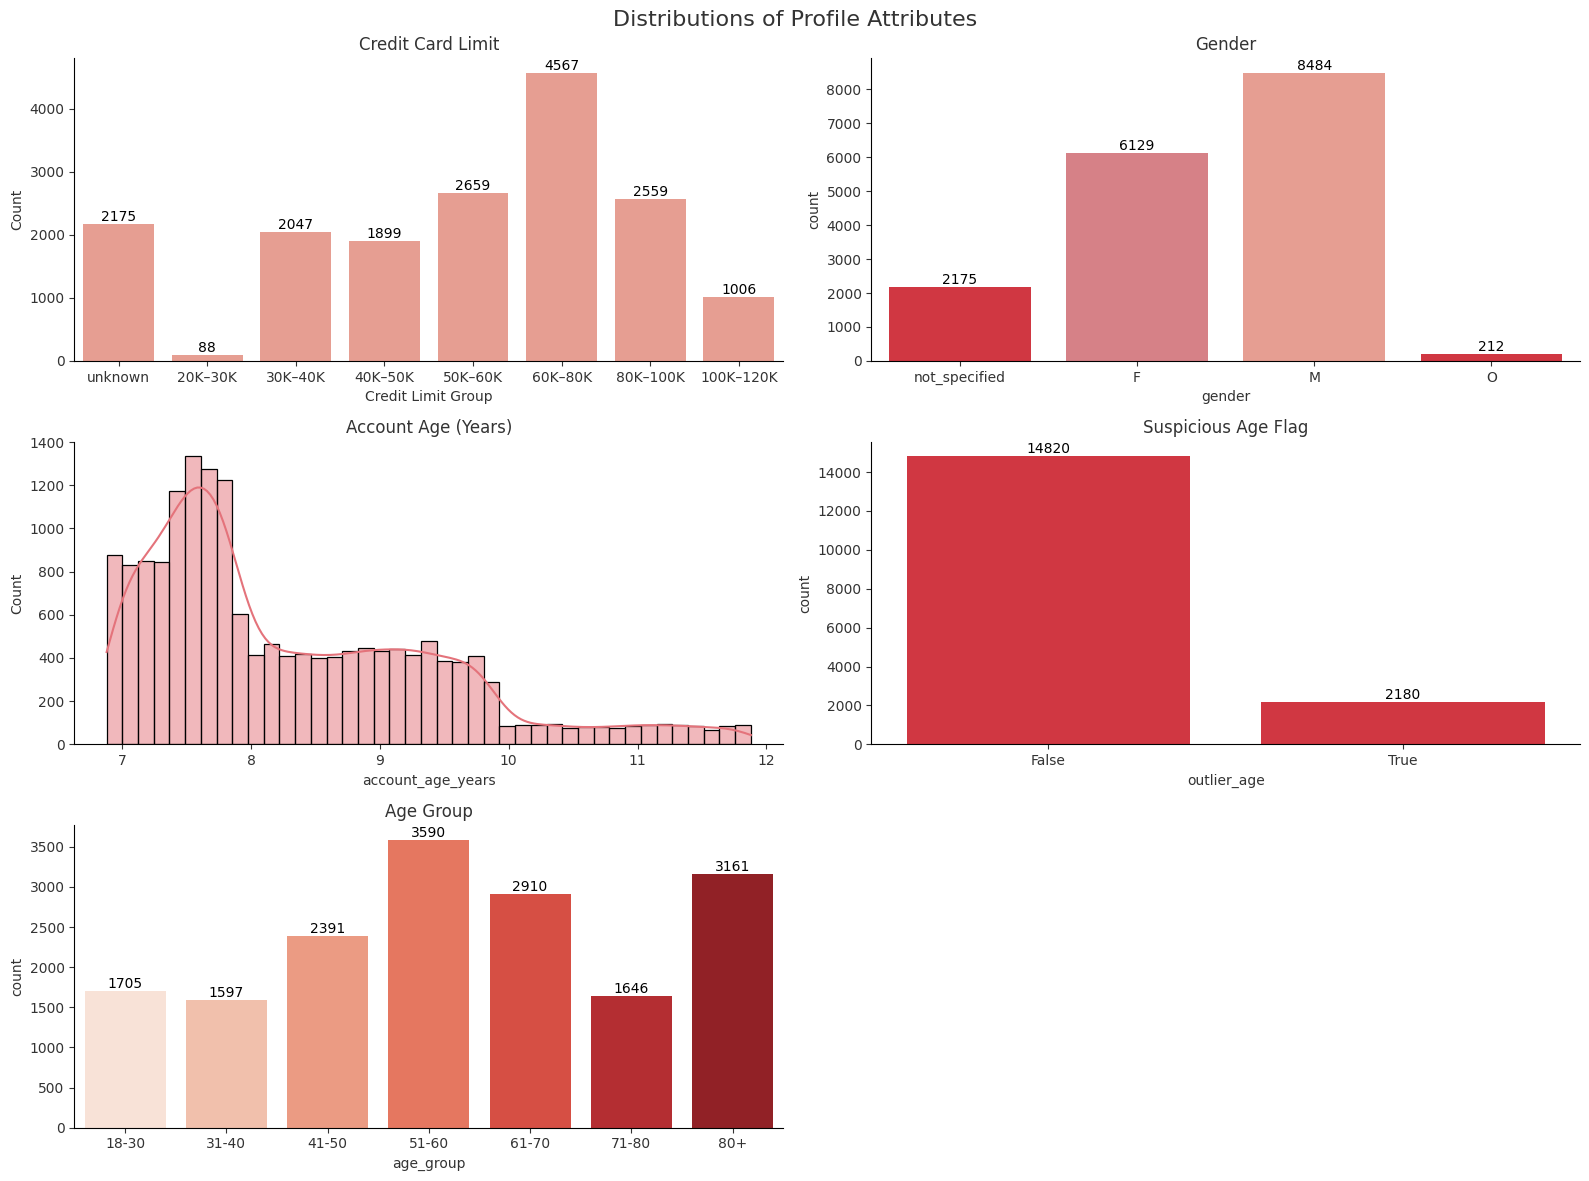

In [0]:
profile_pd = profile_df.toPandas()


fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle("Distributions of Profile Attributes", fontsize=16, color=ifood_palette["black"])

# Plot 1: credit_limit_group (categorized)
order = ["unknown", "≤10K", "10K–20K", "20K–30K", "30K–40K", "40K–50K", "50K–60K", "60K–80K", "80K–100K", "100K–120K", "120K+"]
valid_counts = profile_pd["credit_limit_group"].value_counts().sort_index()
valid_order = [group for group in order if group in valid_counts.index]

sns.countplot(
    data=profile_pd,
    x="credit_limit_group",
    order=valid_order,
    ax=axes[0, 0],
    color=ifood_palette["light_pink"]
)
axes[0, 0].set_title("Credit Card Limit", color=ifood_palette["black"])
axes[0, 0].set_xlabel("Credit Limit Group", color=ifood_palette["black"])
axes[0, 0].set_ylabel("Count", color=ifood_palette["black"])
axes[0, 0].tick_params(colors=ifood_palette["black"])
for container in axes[0,0].containers:
    axes[0,0].bar_label(container, fmt='%.0f')


# Plot 2: gender (categorical)
sns.countplot(data=profile_pd, x="gender", ax=axes[0, 1], palette=[ifood_palette["ifood_red"], ifood_palette["coral"], ifood_palette["light_pink"]])
axes[0, 1].set_title("Gender", color=ifood_palette["black"])
for container in axes[0,1].containers:
    axes[0,1].bar_label(container, fmt='%.0f')

# Plot 3: account_age_years (numeric)
sns.histplot(profile_pd["account_age_years"], kde=True, ax=axes[1, 0], color=ifood_palette["coral"])
axes[1, 0].set_title("Account Age (Years)", color=ifood_palette["black"])

# Plot 4: suspicious_age (categorical)
sns.countplot(data=profile_pd, x="outlier_age", ax=axes[1, 1], color=ifood_palette["ifood_red"])
axes[1, 1].set_title("Suspicious Age Flag", color=ifood_palette["black"])
axes[1, 1].set_xticklabels(["False", "True"])
for container in axes[1,1].containers:
    axes[1,1].bar_label(container, fmt='%.0f')


# Plot 5: age_group (categorical)
sns.countplot(data=profile_pd, x="age_group", order=["18-30", "31-40", "41-50", "51-60", "61-70", "71-80", "80+"], 
              ax=axes[2, 0], palette=sns.color_palette("Reds", n_colors=7))
axes[2, 0].set_title("Age Group", color=ifood_palette["black"])
for container in axes[2,0].containers:
    axes[2,0].bar_label(container, fmt='%.0f')



fig.delaxes(axes[2, 1])


for ax in axes.flat:
    if ax in fig.axes:  
        ax.set_xlabel(ax.get_xlabel(), color=ifood_palette["black"])
        ax.set_ylabel(ax.get_ylabel(), color=ifood_palette["black"])
        ax.tick_params(colors=ifood_palette["black"])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


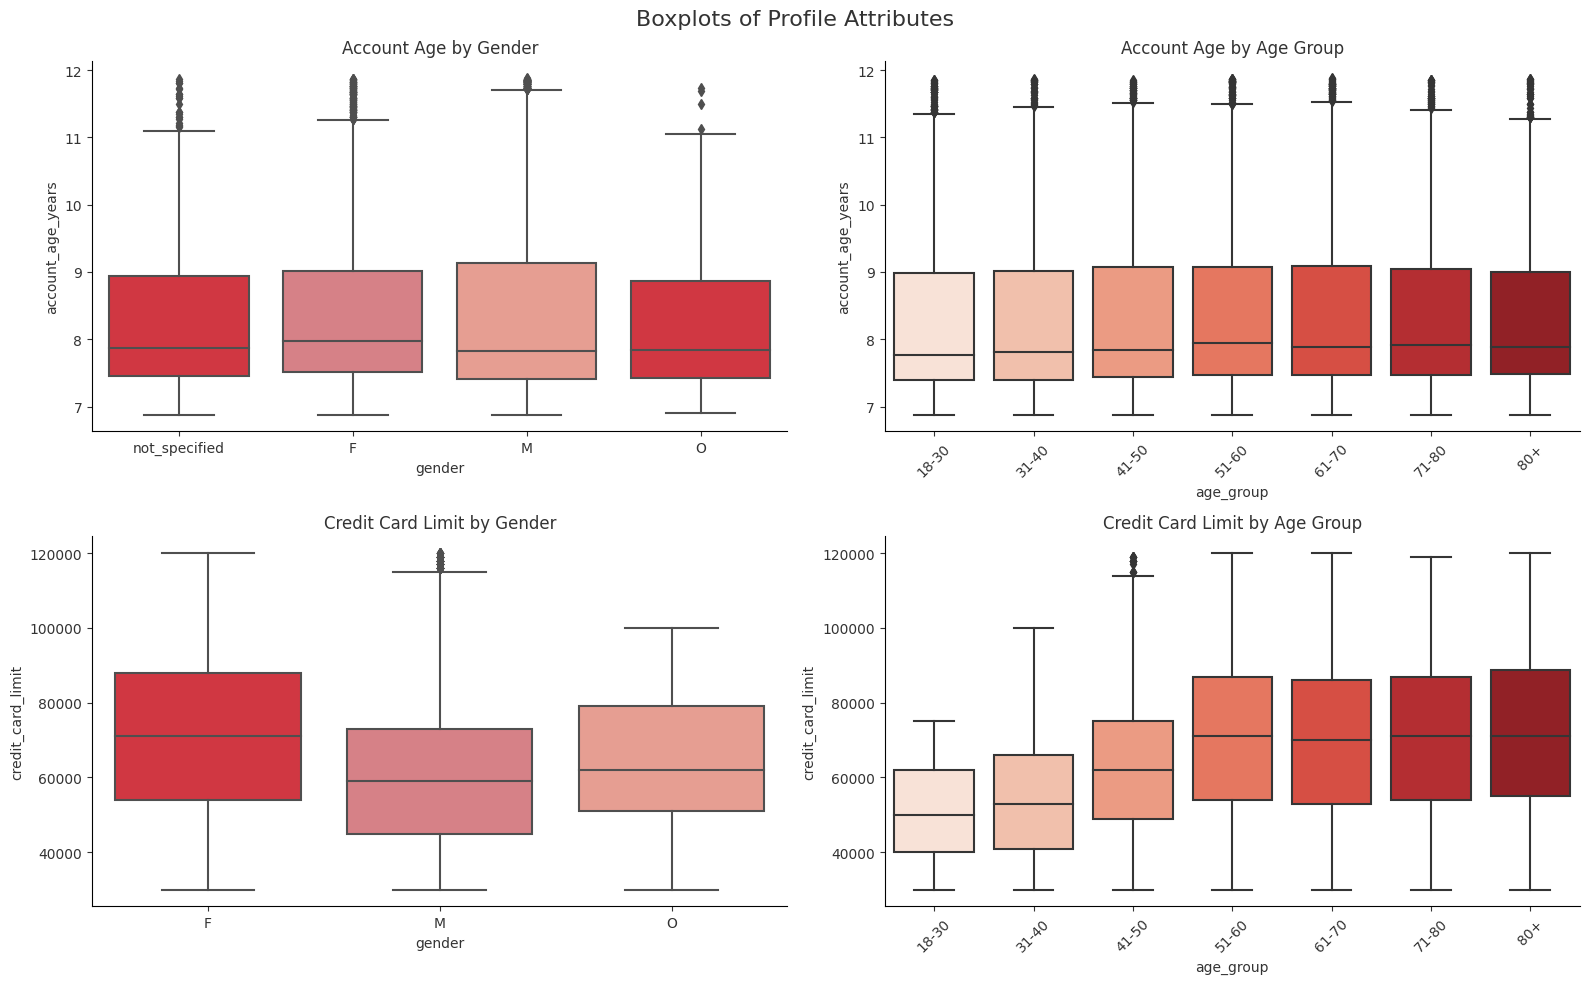

In [0]:
fig, axes = plt.subplots(2, 2, figsize=(16, 10), dpi=100)
fig.suptitle("Boxplots of Profile Attributes", fontsize=16, color=ifood_palette["black"])

# Plot 1: Account Age vs. Gender
sns.boxplot(data=profile_pd, x="gender", y="account_age_years", ax=axes[0, 0],
            palette=[ifood_palette["ifood_red"], ifood_palette["coral"], ifood_palette["light_pink"]])
axes[0, 0].set_title("Account Age by Gender", color=ifood_palette["black"])

# Plot 2: Account Age vs. Age Group
sns.boxplot(data=profile_pd, x="age_group", y="account_age_years", order=[ "18-30", "31-40", "41-50", "51-60", "61-70", "71-80", "80+"],
            ax=axes[0, 1], palette=sns.color_palette("Reds", n_colors=7))
axes[0, 1].set_title("Account Age by Age Group", color=ifood_palette["black"])
axes[0, 1].tick_params(axis="x", rotation=45)

# Plot 3: Credit Card Limit vs. Gender
sns.boxplot(data=profile_pd[profile_pd["credit_card_limit"] != 1],  # Exclui unknown
            x="gender", y="credit_card_limit", ax=axes[1, 0],
            palette=[ifood_palette["ifood_red"], ifood_palette["coral"], ifood_palette["light_pink"]])
axes[1, 0].set_title("Credit Card Limit by Gender", color=ifood_palette["black"])

# Plot 4: Credit Card Limit vs. Age Group
sns.boxplot(data=profile_pd[profile_pd["credit_card_limit"] != 1],
            x="age_group", y="credit_card_limit",
            order=[ "18-30", "31-40", "41-50", "51-60", "61-70", "71-80", "80+"],
            ax=axes[1, 1], palette=sns.color_palette("Reds", n_colors=7))
axes[1, 1].set_title("Credit Card Limit by Age Group", color=ifood_palette["black"])
axes[1, 1].tick_params(axis="x", rotation=45)


for ax in axes.flat:
    ax.set_xlabel(ax.get_xlabel(), color=ifood_palette["black"])
    ax.set_ylabel(ax.get_ylabel(), color=ifood_palette["black"])
    ax.tick_params(colors=ifood_palette["black"])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()

# The distribution of account age is similar across all gender categories. The median account age is around 8 years for each group.Conclusion: Account age appears to be relatively consistent across different gender groups.

# Conclusion: On average, women have higher credit card limits than men in the app.

# There is a positive correlation between user age and credit card limit.


In [0]:

# Pearson correlation 

column_pairs = [
    ("account_age_years", "credit_card_limit"),
    ("age", "credit_card_limit"),
    ("age", "account_age_years")
]

# Calculate pearson correlation for each pair
for col1, col2 in column_pairs:
    df_filtered = profile_pd[profile_pd["credit_card_limit"] != 1]

    r, p_value = pearsonr(df_filtered[col1], df_filtered[col2])
    print(f"Pearson correlation between '{col1}' and '{col2}': r = {r:.3f}, p = {p_value:.3e}")


# Pearson Correlation Insights:
# - Age has a moderate positive correlation with credit card limit: older users tend to have higher limits.
# - Account age has a statistically significant but very weak correlation with credit limit.
# - There is no significant linear correlation between user age and account age — older users are not necessarily longer-term users.


In [0]:
profile_df.display()

age credit_card_limit gender account_id outlier_age registered_on_date account_age_years account_age_group age_group credit_limit_group 118 1.0 not_specified 68be06ca386d4c31939f3a4f0e3dd783 true 2017-02-12 8.33 +5 anos 80+ unknown 55 112000.0 F 0610b486422d4921ae7d2bf64640c50b false 2017-07-15 7.91 +5 anos 51-60 100K–120K 118 1.0 not_specified 38fe809add3b4fcf9315a9694bb96ff5 true 2018-07-12 6.92 +5 anos 80+ unknown 75 100000.0 F 78afa995795e4d85b5d9ceeca43f5fef false 2017-05-09 8.1 +5 anos 71-80 80K–100K 118 1.0 not_specified a03223e636434f42ac4c3df47e8bac43 true 2017-08-04 7.86 +5 anos 80+ unknown 68 70000.0 M e2127556f4f64592b11af22de27a7932 false 2018-04-26 7.13 +5 anos 61-70 60K–80K 118 1.0 not_specified 8ec6ce2a7e7949b1bf142def7d0e0586 true 2017-09-25 7.72 +5 anos 80+ unknown 118 1.0 not_specified 68617ca6246f4fbc85e91a2a49552598 true 2017-10-02 7.7 +5 anos 80+ unknown 65 53000.0 M 389bc3fa690240e798340f5a15918d5c false 2018-02-09 7.34 +5 anos 61-70 50K–60K 118 1.0 not_specified 8974fc5686fe429db53ddde067b88302 true 2016-11-22 8.56 +5 anos 80+ unknown 118 1.0 not_specified c4863c7985cf408faee930f111475da3 true 2017-08-24 7.8 +5 anos 80+ unknown 118 1.0 not_specified 148adfcaa27d485b82f323aaaad036bd true 2015-09-19 9.73 +5 anos 80+ unknown 58 51000.0 M 2eeac8d8feae4a8cad5a6af0499a211d false 2017-11-11 7.59 +5 anos 51-60 50K–60K 61 57000.0 F aa4862eba776480b8bb9c68455b8c2e1 false 2017-09-11 7.75 +5 anos 61-70 50K–60K 26 46000.0 M e12aeaf2d47d42479ea1c4ac3d8286c6 false 2014-02-13 11.33 +5 anos 18-30 40K–50K 62 71000.0 F 31dda685af34476cad5bc968bdb01c53 false 2016-02-11 9.34 +5 anos 61-70 60K–80K 49 52000.0 M 62cf5e10845442329191fc246e7bcea3 false 2014-11-13 10.58 +5 anos 41-50 50K–60K 118 1.0 not_specified 744d603ef08c4f33af5a61c8c7628d1c true 2017-08-01 7.87 +5 anos 80+ unknown 57 42000.0 M 6445de3b47274c759400cd68131d91b4 false 2017-12-31 7.45 +5 anos 51-60 40K–50K 61 40000.0 F a448667f336b42c9a66fc5ffd5d73772 false 2018-05-01 7.12 +5 anos 61-70 30K–40K 40 71000.0 F 440cf1fd7580490c971d8c651ed962af false 2016-05-04 9.11 +5 anos 31-40 60K–80K 64 100000.0 M 4b0da7e80e5945209a1fdddfe813dbe0 false 2017-09-09 7.76 +5 anos 61-70 80K–100K 78 71000.0 F c27e0d6ab72c455a8bb66d980963de60 false 2017-06-16 7.99 +5 anos 71-80 60K–80K 118 1.0 not_specified 2b826eba31074a059d63b0ae8f50b7d5 true 2017-09-07 7.76 +5 anos 80+ unknown 42 69000.0 M f806632c011441378d4646567f357a21 false 2013-08-11 11.84 +5 anos 41-50 60K–80K 56 88000.0 F d058f73bf8674a26a95227db098147b1 false 2018-04-28 7.13 +5 anos 51-60 80K–100K 118 1.0 not_specified 65aba5c617294649aeb624da249e1ee5 true 2017-03-30 8.21 +5 anos 80+ unknown 33 52000.0 F c6c9884912c645429f3333f912b55f44 false 2017-09-26 7.71 +5 anos 31-40 50K–60K 46 59000.0 F 7429a044884842d6862f516c38b1156f false 2017-09-11 7.75 +5 anos 41-50 50K–60K 59 41000.0 M ebe7ef46ea6f4963a7dd49f501b26779 false 2015-01-21 10.39 +5 anos 51-60 40K–50K 67 96000.0 M 5917d13f6fa04286abdf95f4d5cefb1e false 2014-08-23 10.81 +5 anos 61-70 80K–100K 53 52000.0 O d1ede868e29245ea91818a903fec04c6 false 2017-09-16 7.74 +5 anos 51-60 50K–60K 22 70000.0 M 1e9420836d554513ab90eba98552d0a9 false 2017-09-25 7.72 +5 anos 18-30 60K–80K 96 89000.0 F 868317b9be554cb18e50bc68484749a2 false 2017-11-17 7.57 +5 anos 80+ 80K–100K 40 33000.0 M f082d80f0aac47a99173ba8ef8fc1909 false 2016-07-09 8.93 +5 anos 31-40 30K–40K 69 57000.0 F 102e9454054946fda62242d2e176fdce false 2016-08-14 8.83 +5 anos 61-70 50K–60K 118 1.0 not_specified 4beeb3ed64dd4898b0edf2f6b67426d3 true 2016-07-07 8.93 +5 anos 80+ unknown 56 68000.0 M 8dabe2142cdf4013a6f4786edf8ab00f false 2014-05-11 11.09 +5 anos 51-60 60K–80K 26 63000.0 F 9f30b375d7bd4c62a884ffe7034e09ee false 2017-08-12 7.84 +5 anos 18-30 60K–80K 118 1.0 not_specified 25c906289d154b66bf579693f89481c9 true 2018-01-13 7.41 +5 anos 80+ unknown 75 40000.0 M 6e014185620b49bd98749f728747572f false 2015-11-12 9.59 +5 anos 71-80 30K–40K 20 30000.0 F 02c083884c7d45b39cc68e1314fec56c false 2016-07-11 8.92 +5 anos 18-30 20K

In [0]:
# Saving file 

(
    profile_df
    .coalesce(1)                  
    .write
    .mode("overwrite")
    .json("/Volumes/workspace/default/data/profile_processed.json")
)

### 3. Processing **transactions.json**

1. We extracted relevant fields from the `value` struct:
- `amount`: for `transaction` events
- `reward`: for `offer completed` events
- `offer_id`: unified from both `offer_id` and `offer id` keys (due to inconsistent naming)

2. We filtered transaction events and calculated total amount spent by each costumer. 

3. Created a unified DataFrame `journey_df`showing the full journey for each costumer-offer pair:
  - `received_time`: when the offer was received
  - `viewed_time`: when the offer was viewed (if applicable)
  - `completed_time`: when the offer was completed (if applicable)
  - `reward`: reward value for completed offers
  - `total_spent`: overall spend by costumer

In [0]:
transactions_df.groupBy("event").count().orderBy("count", ascending=False).show()

In [0]:
transactions_df.describe().show()

#Check for null values 
transactions_df.select(
    sum(col("account_id").isNull().cast("int")).alias("null_id"),
    sum(col("event").isNull().cast("int")).alias("null_events"),
    sum(col("time_since_test_start").isNull().cast("int")).alias("null_time")
).show()



In [0]:
transactions_df.printSchema()


In [0]:
# Extracting fields from the 'value' struct column:
# - Creates separate columns for 'amount', 'reward', and 'offer_id'
# - Unify 'offer_id' from either 'offer_id' or 'offer id'

transactions_df = transactions_df \
    .withColumn("amount", col("value.amount")) \
    .withColumn("reward", col("value.reward")) \
    .withColumn("offer_id_underscore", col("value.offer_id")) \
    .withColumn("offer_id_space", col("value.`offer id`"))

transactions_df = transactions_df.withColumn(
    "offer_id", coalesce(col("offer_id_underscore"), col("offer_id_space"))
)

# Backup value
backup_transactions_df = transactions_df
#drop repeated columns
transactions_df = transactions_df.drop("offer_id_underscore", "offer_id_space", "value")

transactions_df.printSchema()


In [0]:
# Splitting transactional events into separate DataFrames:

received_df = transactions_df.filter(col("event") == "offer received") \
    .select("account_id", "offer_id", col("time_since_test_start").alias("received_time"))

viewed_df = transactions_df.filter(col("event") == "offer viewed") \
    .select("account_id", "offer_id", col("time_since_test_start").alias("viewed_time"))

completed_df = transactions_df.filter(col("event") == "offer completed") \
    .select("account_id", "offer_id", col("time_since_test_start").alias("completed_time"), "reward")


In [0]:
# Merge offer stages (received -> viewed -> completed) with customer spending

journey_df = received_df \
    .join(viewed_df, ["account_id", "offer_id"], how="left") \
    .join(completed_df, ["account_id", "offer_id"], how="left") \
    .join(transactions_only_df, on="account_id", how="left")




In [0]:
# Percentage of Received Offers That Were Completed
journey_df.select(
    count("*").alias("total_offers"),
    count(when(col("completed_time").isNotNull(), True)).alias("completed_offers")
).withColumn(
    "conversion_rate", col("completed_offers") / col("total_offers")
).show()

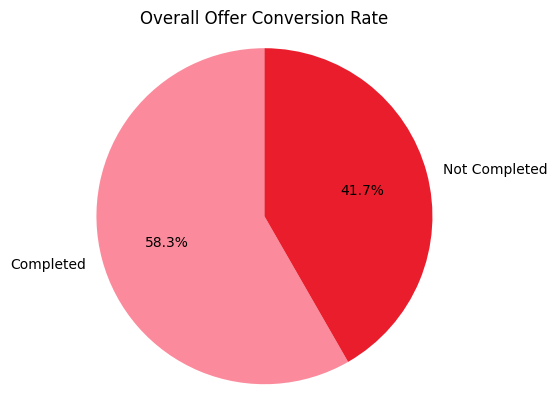

In [0]:

# Visualizing Received Offers That Were Completed
journey_df = journey_df.withColumn("completed_flag", when(col("completed_time").isNotNull(), True).otherwise(False))
journey_pd = journey_df.select("completed_flag").toPandas()
conversion_counts = journey_pd["completed_flag"].value_counts()
labels = ["Completed", "Not Completed"]
colors = [ifood_palette["mid_pink"], ifood_palette["ifood_red"]]

plt.pie(conversion_counts, labels=labels, autopct="%1.1f%%", colors=colors, startangle=90)
plt.title("Overall Offer Conversion Rate")
plt.axis("equal")
plt.show()

# Over half of the received offers were completed, with a conversion rate of approximately 58%.
# However, there is still room to optimize the experience for the 42% who do not complete the offer.

In [0]:
# Influence of Offer Visualization

journey_df.select(
    count("*").alias("total"),
    count(when(col("viewed_time").isNotNull(), True)).alias("viewed"),
    count(when(col("completed_time").isNotNull(), True)).alias("completed"),
    count(when((col("viewed_time").isNotNull()) & (col("completed_time").isNotNull()), True)).alias("viewed_and_completed")
).show()


In [0]:
# Average Time to Offer Completion
journey_df = journey_df.withColumn(
    "time_to_complete", col("completed_time") - col("received_time")
)

journey_df.filter(col("time_to_complete").isNotNull()) \
    .select(round(avg("time_to_complete"), 2).alias("avg_days_to_complete")) \
    .show()

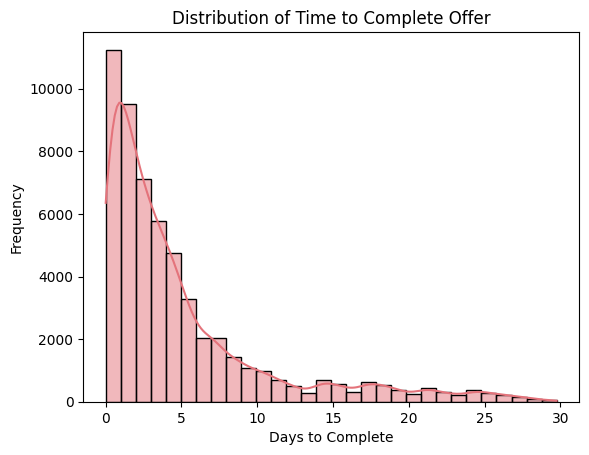

In [0]:
# Visualizing Average Time to Offer Completion
journey_pd = journey_df.toPandas()
journey_pd = journey_pd[journey_pd["time_to_complete"] >= 0]
sns.histplot(journey_pd["time_to_complete"].dropna(), bins=30, kde=True, color=ifood_palette["coral"])
plt.title("Distribution of Time to Complete Offer")
plt.xlabel("Days to Complete")
plt.ylabel("Frequency")
plt.show()

# Most users complete the offer within the first few days after receiving it.
# The distribution is right-skewed, indicating that quick completions are common, while longer durations rarely lead to completion.


In [0]:
    
# Average Spending of Users Who Complete vs. Do Not Complete the Offer
journey_df.select(
    when(col("completed_time").isNotNull(), "Completed").otherwise("Not Completed").alias("status"),
    "total_spent"
).groupBy("status").agg(
    count("*").alias("n_customers"),
    round(avg("total_spent"), 2).alias("avg_spent")
).show()

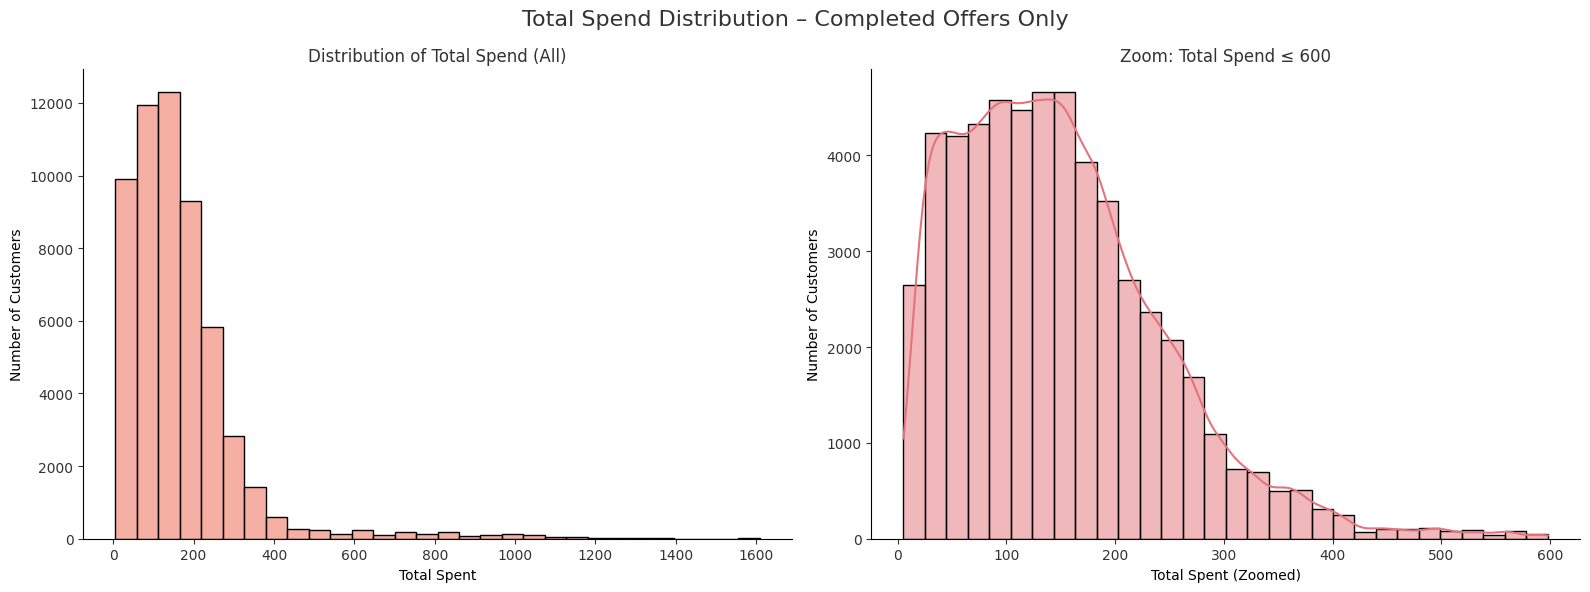

In [0]:
# Total customer spent only for completed distribution

completed_only = journey_pd[journey_pd["completed_time"].notna()]

fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=100)
fig.suptitle("Total Spend Distribution – Completed Offers Only", fontsize=16, color=ifood_palette["black"])

#Plot 1: full distribution
sns.histplot(completed_only["total_spent"], bins=30, ax=axes[0], color=ifood_palette["light_pink"])
axes[0].set_title("Distribution of Total Spend (All)", color=ifood_palette["black"])
axes[0].set_xlabel("Total Spent")
axes[0].set_ylabel("Number of Customers")

# Plot 2: zoom in spent in [0,600]
sns.histplot(completed_only[completed_only["total_spent"] <= 600]["total_spent"],
             bins=30, kde=True, ax=axes[1], color=ifood_palette["coral"])
axes[1].set_title("Zoom: Total Spend ≤ 600", color=ifood_palette["black"])
axes[1].set_xlabel("Total Spent (Zoomed)")
axes[1].set_ylabel("Number of Customers")

# Ajustes visuais
for ax in axes:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.tick_params(colors=ifood_palette["black"])

plt.tight_layout()
plt.show()

In [0]:
transactions_df.groupBy("event").agg(
    sum(col("amount").isNull().cast("int")).alias("null_amount"),
    sum(col("reward").isNull().cast("int")).alias("null_reward"),
    sum(col("offer_id").isNull().cast("int")).alias("null_offer_id")
).show()

In [0]:
# Saving file 
(
    transactions_df
    .coalesce(1)                  
    .write
    .mode("overwrite")
    .json("/Volumes/workspace/default/data/transactions_df.json")
)

### 4. Unifying datasets

In [0]:

# Transactions and offers (by offer_id)
full_df = transactions_df.join(offers_df, on="offer_id", how="left")


# 2. Adding  profile (by account_id)
full_df = full_df.join(profile_df, on="account_id", how="left")


In [0]:
df_valid = full_df.filter(col("reward").isNotNull() & col("discount_value").isNotNull())
df = df_valid.withColumn("columns_equal", col("discount_value") == col("reward"))
df_equal = df.filter(col("discount_value") == col("reward"))

print("Total rows with valid entrances in reward and discount_value:", df_valid.count())
print("Rows where reward == discount_value:", df_equal.count())

# All valid entries in the "reward" and "discount_value" columns are equal.
# The number of matches (33,579) is exactly the number of non-null values in "offer completed" events.
# This confirms that whenever offer is completed, the reward is consistently recorded as a discount in the transaction.


In [0]:
# Droping 'reward', since discount_value is valid for completed and incompleted offers
full_df = full_df.drop("reward")

In [0]:

full_pd = full_df.toPandas()
numeric_df = full_pd.select_dtypes(include=["int64", "float64"])
correlation_matrix = numeric_df.corr(method="pearson")


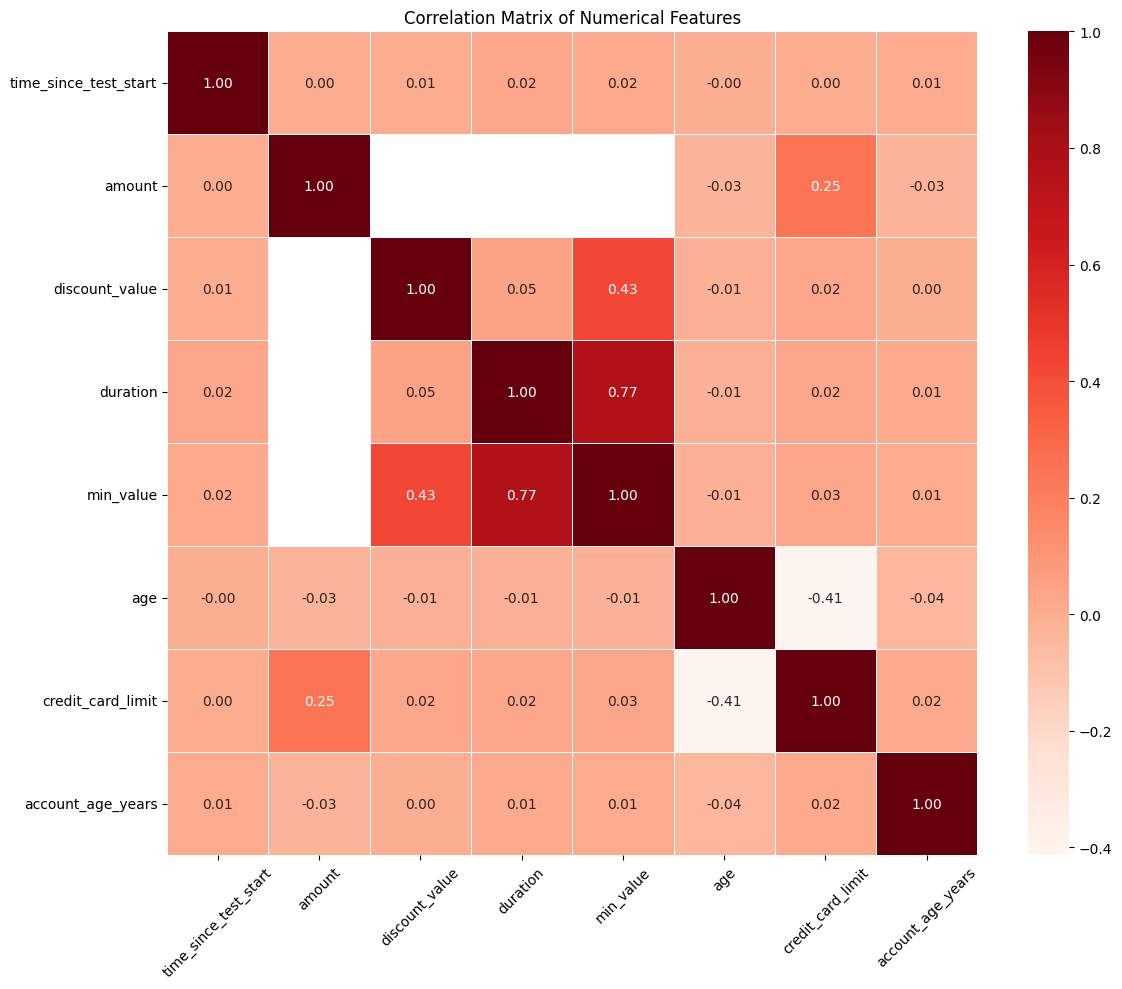

In [0]:
plt.figure(figsize=(12, 10), dpi=100)
sns.heatmap(correlation_matrix, annot=True, cmap="Reds", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Numerical Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Strong Positive Correlation Between duration and min_value (0.77): suggests that offers with higher minimum spending requirements tend to have longer durations. 

# Negative Correlation Between reward and duration (-0.47): Offers with higher rewards tend to have shorter durations.

In [0]:
# Include offer_type in dataset
journey_with_type = journey_df.join(offers_df.select("offer_id", "offer_type"), journey_df["offer_id"] == offers_df["offer_id"], how="left")

# Conversion rate = % de completadas por tipo
conversion_by_type = journey_with_type.groupBy("offer_type").agg(
    count("*").alias("total_offers"),
    count(when(col("completed_time").isNotNull(), True)).alias("completed_offers")
).withColumn(
    "conversion_rate", col("completed_offers") / col("total_offers")
)

conversion_by_type.show()
# Discount offers have the highest conversion rate at 73.25%
# BOGO offers also perform well, with a conversion rate of 65.76%

###  5. Feature Engineering

In [0]:
# Explode channels (array)
offers_exploded = offers_df.select("offer_id", explode("channels").alias("channel"))

# Adds channel information to each record in journey_df
journey_with_channels = journey_df.join(offers_exploded, journey_df["offer_id"] == offers_exploded["offer_id"], how="left")

# Conversion rate by channel:
conversion_by_channel = journey_with_channels.groupBy("channel").agg(
    count("*").alias("total_offers"),
    count(when(col("completed_time").isNotNull(), True)).alias("completed_offers")
).withColumn(
    "conversion_rate", col("completed_offers") / col("total_offers")
)

conversion_by_channel.show()

# Web channel has the highest conversion rate at 63.92%
# Social media has a conversion rate of 62.23%
# Mobile (58.48%) and email (58.30%) show similar conversion rates
# Web and social channels stand out as the most effective in driving offer completions.


In [0]:

# Ploting conversion rate by offer type and channel
conversion_by_type_df = pd.DataFrame({
    'offer_type': ['bogo', 'discount', 'informational'],
    'conversion_rate': [0.66, 0.73, 0.0]
})

conversion_by_channel_df = pd.DataFrame({
    'channel': ['email', 'web', 'mobile', 'social'],
    'conversion_rate': [0.58, 0.64, 0.58, 0.62]
})

# # Plotting
# fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# # Conversion by offer type
# axes[0].bar(conversion_by_type_df['offer_type'], conversion_by_type_df['conversion_rate'], color=ifood_palette['mid_pink'])
# axes[0].set_title('Conversion Rate by Offer Type')
# axes[0].set_ylabel('Conversion Rate')
# axes[0].set_ylim(0, 1)

# # Conversion by channel
# axes[1].bar(conversion_by_channel_df['channel'], conversion_by_channel_df['conversion_rate'], color=ifood_palette['coral'])
# axes[1].set_title('Conversion Rate by Channel')
# axes[1].set_ylabel('Conversion Rate')
# axes[1].set_ylim(0, 1)

# plt.tight_layout()
# plt.show()


In [0]:
# Groups rows by each unique customer (account_id)
customer_window = Window.partitionBy("account_id")

# Counts how many offers each customer has received and each has completed.
# Calculate personal conversion rate: completed offers/received offers.
# Counts the number of transactions the user made.
# Calculates the average transaction amount per user (only considering rows where event == "transaction").

df_full = full_df \
    .withColumn("n_offers_received", count(when(col("event") == "offer received", True)).over(customer_window)) \
    .withColumn("n_offers_viewed", count(when(col("event") == "offer viewed", True)).over(customer_window)) \
    .withColumn("n_offers_completed", count(when(col("event") == "offer completed", True)).over(customer_window)) \
    .withColumn("conversion_rate", col("n_offers_completed") / col("n_offers_received")) \
    .withColumn("n_transactions", count(when(col("event") == "transaction", True)).over(customer_window)) \
    .withColumn("avg_transaction", avg(when(col("event") == "transaction", col("amount"))).over(customer_window))



In [0]:
df_full = df_full.withColumn(
    "account_age_group",
    when(col("account_age_years") <= 0.082, "0–30 dias")
    .when(col("account_age_years") <= 0.493, "31–180 dias")
    .when(col("account_age_years") <= 1.0, "181–365 dias")
    .when(col("account_age_years") <= 2.0, "1–2 anos")
    .when(col("account_age_years") <= 5.0, "2–5 anos")
    .otherwise("+5 anos")
)

In [0]:

# Adding number of transactions, total amount spent, average transaction value
full_df = full_df \
    .withColumn("n_transactions", count(when(col("event") == "transaction", True)).over(customer_window)) \
    .withColumn("total_spent", sum(when(col("event") == "transaction", col("amount"))).over(customer_window)) \
    .withColumn("avg_transaction", expr("try_divide(total_spent, n_transactions)"))


In [0]:
# Adding how many different channels the customer has interacted with and how many different types of offers they've received
full_df = full_df \
    .withColumn("distinct_channels", size(collect_set("channels").over(customer_window))) \
    .withColumn("distinct_offer_types", size(collect_set("offer_type").over(customer_window)))

In [0]:
# Engagement score as: (offers_viewed + offers_completed) / offers_received
df_full = df_full.withColumn(
    "engagement_score",
    (col("n_offers_viewed") + col("n_offers_completed")) / col("n_offers_received")
)

# Score = 0: The user received offers but did not view or complete any of them.
# 0 < Score < 1: The user viewed or completed some of the received offers.
# Score = 1: The total number of views + completions equals the number of offers received. If the user did not complete an offer, it means the user interacted with every offer at least once.
# Score > 1: The user both viewed and completed offers, indicating high engagement 

In [0]:

# Grouping conversion rate by categories to plot
df_age_group = (
    df_full.groupBy("age_group", "offer_type")
    .agg((sum("n_offers_completed") / sum("n_offers_received")).alias("conversion_rate"))
    .orderBy("age_group", "offer_type")
    .toPandas()
)

df_account_age = (
    df_full.groupBy("account_age_group", "offer_type")
    .agg((sum("n_offers_completed") / sum("n_offers_received")).alias("conversion_rate"))
    .orderBy("account_age_group", "offer_type")
    .toPandas()
)

df_credit_group = (
    df_full.groupBy("credit_limit_group")
    .agg((sum("n_offers_completed") / sum("n_offers_received")).alias("conversion_rate"))
    .orderBy("credit_limit_group")
    .toPandas()
)

In [0]:
df_account_age.display()

account_age_group offer_type conversion_rate +5 anos null 0.5227931629125754 +5 anos bogo 0.5133770093524077 +5 anos discount 0.5342414106164208 +5 anos informational 0.3545345656431589

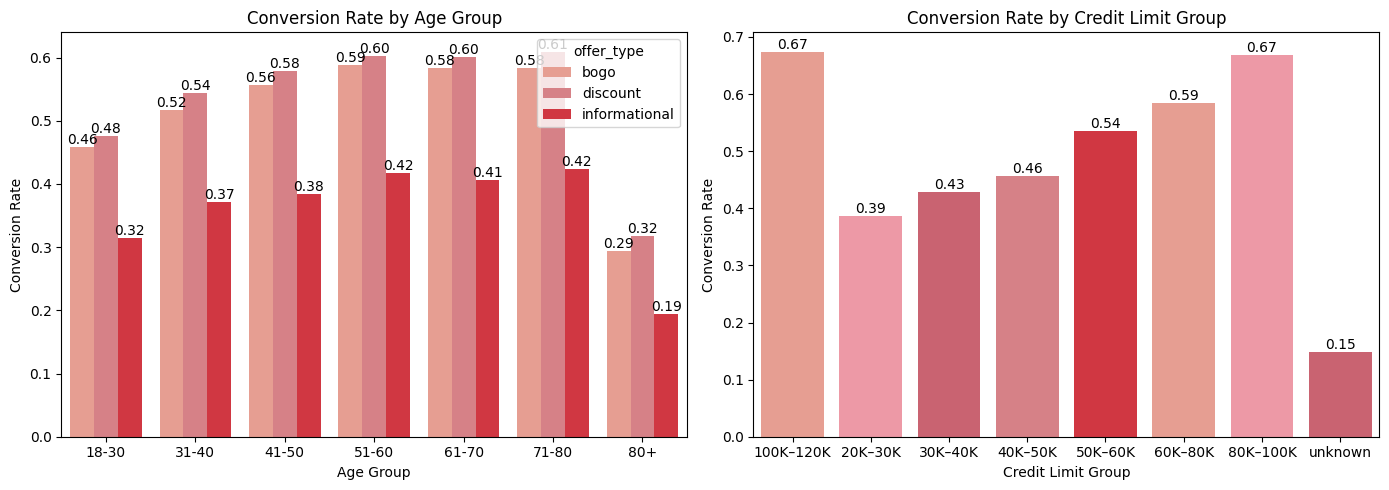

In [0]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5), dpi=100)

# Plot 1: Conversion by age group
sns.barplot(
    data=df_age_group, x="age_group", y="conversion_rate", hue="offer_type",
    ax=axes[0], palette={
                            "bogo": ifood_palette["light_pink"],
                            "discount": ifood_palette["coral"],
                            "informational": ifood_palette["ifood_red"]
    }
)
axes[0].set_title("Conversion Rate by Age Group")
axes[0].set_ylabel("Conversion Rate")
axes[0].set_xlabel("Age Group")
for container in axes[0].containers:
    axes[0].bar_label(container, fmt='%.2f')

# Plot 2: Conversion by credit limit group
sns.barplot(
    data=df_credit_group,
    x="credit_limit_group", y="conversion_rate",
    ax=axes[1], palette = [
    ifood_palette["light_pink"],
    ifood_palette["mid_pink"],
    ifood_palette["pink"],
    ifood_palette["coral"],
    ifood_palette["ifood_red"]
]
)
axes[1].set_title("Conversion Rate by Credit Limit Group")
axes[1].set_ylabel("Conversion Rate")
axes[1].set_xlabel("Credit Limit Group")
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%.2f')

plt.tight_layout()
plt.show()


In [0]:
df_full = df_full.withColumn(
    "potential",
    when(col("n_offers_completed")>0, 1)
    .otherwise(0)
)

df_full = df_full.withColumn(
    "avg_amount",
    avg(when(col("amount") > 0, col("amount"))).over(customer_window)
)


df_full = df_full.withColumn(
    "spending_ratio",
    coalesce(expr("try_divide(avg_amount, min_value)"), lit(0))
)

# spending_ratio > 1: user spends more than the minimum value — high chance of conversion.
# spending_ratio < 1: user spends less than the minimum value — might not convert.
# spending_ratio = 1: user spends is aligned with the offer’s minimum — borderline case.


In [0]:
# Saving file 
spark.conf.set("spark.sql.ansi.enabled", "false")

(
    df_full
    .coalesce(1)                  
    .write
    .mode("overwrite")
    .json("/Volumes/workspace/default/data/full_dataset_processed.json")
)

###  6. Preparing Training dataset

In [0]:
#Exclude outlier_age = True
df_full = df_full.filter(col("outlier_age") == False)


In [0]:
df_full = df_full.withColumn(
    "offer_type", 
    when(col("offer_type") == "informational", 0)
    .when(col("offer_type") == "bogo", 1)
    .when(col("offer_type") == "discount", 2)
    .otherwise(-1) 
).fillna(0)

In [0]:
selected_columns = [
    "account_id", "offer_id", "offer_type", "min_value", "discount_value", "duration",
    "n_transactions", "n_offers_received", "n_offers_viewed", "n_offers_completed", "conversion_rate", "engagement_score", "potential", "avg_amount", "spending_ratio"
    , "age", "credit_card_limit"
]

In [0]:
train_df = df_full.select(selected_columns)

In [0]:
#Saving file
train_df.write.mode("overwrite").saveAsTable("train_df_json")